Model selection and cross-validation for 3D static OC modeling
---------------------------------------------------------------

This notebook trains multiple models for soil Organic Carbon predictions at multiple depths at one given time (static model). The model training data is based on soil data that is taken at sample sites in L'lara. The prediction models that are tested are based on Gaussian Process regression with two different base function: Random Forest and Bayesian Linear Regression.

The model selection is based on the cross-validation of the prediction error (normalized RMSE, R2) for the test data.
Test data is selected based on n-fold cros-validation. Different test data is selected for each fold. Note that test data is n-fold split based on the spatial location of the probes only (test location per drill).

User settings, such as input/output paths and all other options, are set in the settings file, e.g.: `settings_testmodels_static.yaml`

The covariate features have been selected in previous workflow step (see notebook `feature_importance_static.ipynb`).

This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).

## Library imports

In [1]:
# Import libraries
import os 
import sys
import yaml
import shutil
from types import SimpleNamespace  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from selectio import selectio

# Import custom modules 
sys.path.append('../python_scripts')
from preprocessing import gen_kfold
import soilmod_xval as xval

## Read and process feature importance settings

 Settings are specified in the .yaml file for reproducible analysis. Below we will read and inspect the settings.

In [2]:
# Define name of settings file to save configuration:
fname_settings = 'settings_testmodels_static.yaml'
# Path to settings file:
path_settings = 'settings'

In [3]:
# Load settings from yaml file:
with open(os.path.join(path_settings,fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
# Parse settings dictionary as namespace (settings are available as 
# settings.variable_name rather than settings['variable_name'])
settings = SimpleNamespace(**settings)

# Verify output directory and make it if it does not exist:
os.makedirs(settings.outpath, exist_ok = True)

# Print settings:
print("Main Settings:")
print("----------------")
for key in settings.__dict__:
    if key != "name_features":
        print(f"settings.{key} : {settings.__dict__[key]}")

# Print features selected
print("")
print("Available Features:")
print("----------------")
for key in settings.__dict__:
    if key == "name_features":
        for feature in settings.name_features:
            print(f"'{feature}'")

Main Settings:
----------------
settings.inpath : samples/
settings.outpath : results/Llara_xval_static3d/
settings.infname : soildata_static3d.csv
settings.project_crs : EPSG:28355
settings.name_target : OC_WB
settings.colname_xcoord : Easting
settings.colname_ycoord : Northing
settings.colname_zcoord : mid_depth
settings.model_functions : ['blr-gp', 'rf', 'rf-gp', 'blr']
settings.name_ixval : nfold
settings.nfold : 8
settings.axistype : vertical
settings.zmin : 0
settings.zmax : 100

Available Features:
----------------
'mid_depth'
'NDVI_50'
'NDVI_95'
'silica'
'rad_u'
'EM'


### Data Preprocessing

The data preprocessing includes the following steps:
 - reading in the dataset from .csv file into pandas dataframe
 - checking coordinate names and converting if necessary to default name convention (x,y,z)
 - select data for top soil only
 - generating n-fold cross-validation test sets
 - converting coordinates to origin at x,y = 0,0

In [4]:
print('Reading data into dataframe...')
# Read in data
dfsel = pd.read_csv(os.path.join(settings.inpath, settings.infname))

# Rename input data to x, y, z coordinate names
if settings.colname_xcoord != 'x':
    dfsel.rename(columns={settings.colname_xcoord: 'x'}, inplace = True)
if settings.colname_ycoord != 'y':
    dfsel.rename(columns={settings.colname_ycoord: 'y'}, inplace = True)
if (settings.axistype == 'vertical') & (settings.colname_zcoord != 'z'):
    dfsel.rename(columns={settings.colname_zcoord: 'z'}, inplace = True)
    if settings.colname_zcoord in settings.name_features:
        print('Adding z coordinate to feature list...')
        settings.name_features.remove(settings.colname_zcoord)
        settings.name_features.append('z')

# Select data between zmin and zmax
dfsel = dfsel[(dfsel['z'] >= settings.zmin) & (dfsel['z'] <= settings.zmax)]

# Generate n-fold indices
print(f'Generating {settings.nfold}-fold test sets based on moisture probe locations..')
#dfsel = gen_kfold(dfsel, nfold = settings.nfold, label_nfold = 'nfold', id_unique = ['x', 'y', 'z'], precision_unique = 0.01)
dfsel = gen_kfold(dfsel, nfold = settings.nfold, label_nfold = 'nfold', id_unique = ['x', 'y'], precision_unique = 0.01)

## Get coordinates for training data and set coord origin to (0,0)
print(f'Setting coordinate origin to (0,0)...')
bound_xmin = dfsel.x.min()
bound_xmax = dfsel.x.max()
bound_ymin = dfsel.y.min()
bound_ymax = dfsel.y.max()

# Set origin to (0,0)
dfsel['x'] = dfsel['x'] - bound_xmin
dfsel['y'] = dfsel['y'] - bound_ymin

print('Preprocessing data finished.')

Reading data into dataframe...
Adding z coordinate to feature list...
Generating 8-fold test sets based on moisture probe locations..
Setting coordinate origin to (0,0)...
Preprocessing data finished.


### Train and test multiple models

Here we train and test multiple models as specified in the settings: settings.model_functions.
The models are a combination of Gaussian Process regression with either a Random Forest or Bayesian linear regression model as base function.

This training step will take a couple of minutes given that a new model needs to be trained and evaluated for each cross-validation and model type.

The results for each model are saved as:
- R2
- RMSE normalized to standard deviation
- Theta: Mean ratio of true error squared divided by predicted error squared for test data

In [5]:
# Define stats result lists
nrmse_meanfunction = []
nrmse_meanfunction_std = []
theta_meanfunction = []
theta_meanfunction_std = []
r2_meanfunction = []
r2_meanfunction_std = []

# Loop over model functions and evaluate
for model_function in settings.model_functions:
    # run and evaluate model
    dfsum, stats_summary, model_outpath = xval.runmodel(dfsel, model_function, settings)
    print(f'All output files of {model_function} saved in {model_outpath}')
    print('')
    # save results
    nrmse_meanfunction.append(stats_summary[0])
    nrmse_meanfunction_std.append(stats_summary[1])
    theta_meanfunction.append(stats_summary[2])
    theta_meanfunction_std.append(stats_summary[3])
    r2_meanfunction.append(stats_summary[4])
    r2_meanfunction_std.append(stats_summary[5])


Computing 8-fold xrossvalidation for function model: blr-gp
Processing for nfold  1
Mean of Y:  -0.0 +/- 0.1622
Mean of Mean function:  0.6906 +/- 0.1761
Mean of Mean function noise: 0.1659 +/- 0.0013
Optimizing GP hyperparameters...
Mean Input Noise:  1.0226004983164378
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [2.78331328e-01 1.66100351e-04 9.62746618e+01 5.01834614e+03]
Marginal Log Likelihood:  -366.8560348183883
Computing GP predictions for test set nfold  1
Logl:  -366.6604790587362
Logl:  -366.6604790587362
GP Marginal Log-Likelihood:  -366.66
Normalized RMSE:  0.6232
Normalized ROOT MEDIAN SE:  0.3754
R^2:  0.6116
Mean Theta:  0.5247
Median Theta:  0.0
Processing for nfold  2
Mean of Y:  -0.0 +/- 0.1521
Mean of Mean function:  0.6701 +/- 0.1675
Mean of Mean function noise: 0.1556 +/- 0.0012
Optimizing GP hyperparameters...
Mean Input Noise:  1.0226034208024803
Optimized Hyperparameters (amplitude, y_noise_fac, lengthscale_z, lengths_xy): [2.

### Sort models based on RMSE

In [6]:
#End of xval loop over all models
#Print best models sorted with nRMSE
ix_meanfunction_sorted = [nrmse_meanfunction.index(x) for x in sorted(nrmse_meanfunction)]
print('')
print('-------------------------------')
print('Models ranked based on nRMSE:')
print('')
for ix in ix_meanfunction_sorted:
    print(f'{settings.model_functions[ix]}: Mean nRMSE = {nrmse_meanfunction[ix]:.3f} +/- {nrmse_meanfunction_std[ix]:.3f}')
    print(f'Mean R2= {r2_meanfunction[ix]:.3f} +/- {r2_meanfunction_std[ix]:.3f}')
    print(f'Theta = {theta_meanfunction[ix]:.3f} +/- {theta_meanfunction_std[ix]:.3f}')


-------------------------------
Models ranked based on nRMSE:

blr: Mean nRMSE = 0.710 +/- 0.091
Mean R2= 0.488 +/- 0.135
Theta = 1.089 +/- 0.554
blr-gp: Mean nRMSE = 0.718 +/- 0.101
Mean R2= 0.475 +/- 0.159
Theta = 0.995 +/- 0.460
rf-gp: Mean nRMSE = 0.721 +/- 0.113
Mean R2= 0.467 +/- 0.176
Theta = 1.257 +/- 0.484
rf: Mean nRMSE = 0.745 +/- 0.107
Mean R2= 0.434 +/- 0.172
Theta = 1.352 +/- 0.511


### Show summary of results

Results for each cross-validation set (here 8) are saved in a separate folder, including csv files, multiple plots for residual analysis and ground truth versus prediction. To inspect please check images in output folder. Here we show only a few overview results of the combined cross-validation results.

#### Show results for best model: GP Model with Bayesian Linear regression base function



---- Summary stats for GP - RF model model ----
Mean normalized RMSE = 0.718 +/- 0.101
Mean R2 = 0.475 +/- 0.159
Mean Theta = 0.995 +/- 0.460


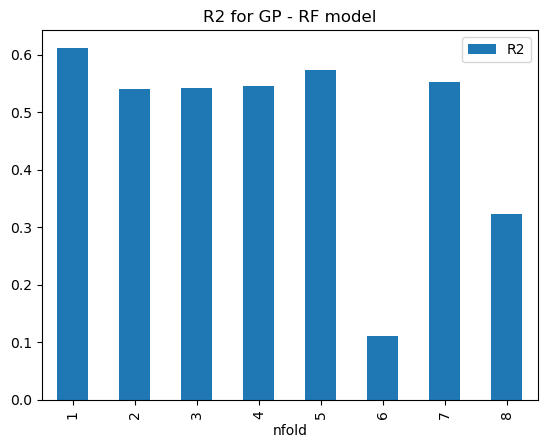

Image files generated:  ['Xvalidation_Residual_hist_OC_WB.png', 'pred_vs_trueOC_WB_combined.png']
Best R2 result for X-val fold: 1
Worst R2 result for X-val fold: 6


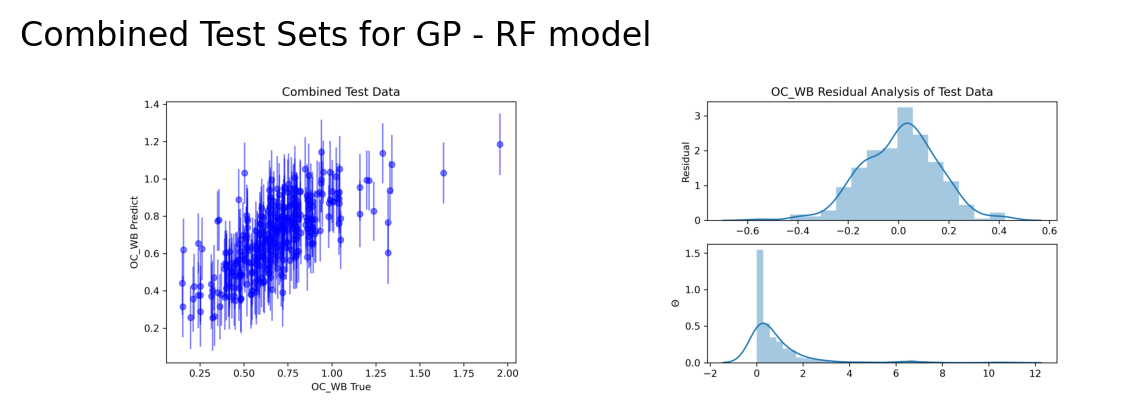

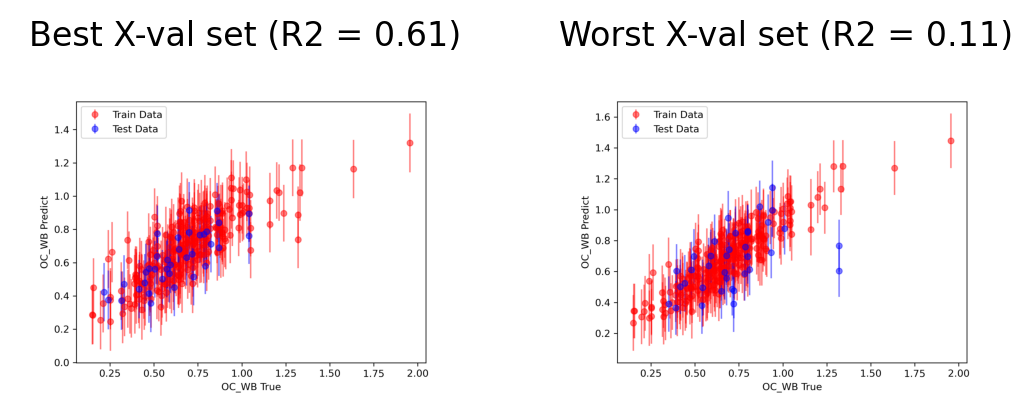

In [7]:
# Read in summary stats
modelname = 'GP - RF model'
respath = os.path.join(settings.outpath, 'Xval_8-fold_blr-gp_OC_WB')

dfstats = pd.read_csv(os.path.join(respath,'OC_WBnfold_summary_stats.csv'))

# print mean nRMSE and R2
print(f'---- Summary stats for {modelname} model ----')
print(f'Mean normalized RMSE = {np.mean(dfstats.nRMSE):.3f} +/- {np.std(dfstats.nRMSE):.3f}')
print(f'Mean R2 = {np.mean(dfstats.R2):.3f} +/- {np.std(dfstats.R2):.3f}')
print(f'Mean Theta = {np.mean(dfstats.Theta):.3f} +/- {np.std(dfstats.Theta):.3f}')

dfstats.plot(y='R2', x = 'nfold', kind = 'bar', title = f'R2 for {modelname}')
plt.show()

# Plot combined test data
files = os.listdir(respath)
pngfiles = [name for name in files if name.endswith('.png')]
print('Image files generated: ', pngfiles)
fig, ax = plt.subplots(1,2, dpi =200)
img = imread(f"{respath}/pred_vs_trueOC_WB_combined.png", format='PNG')
ax[0].set_axis_off()
ax[0].imshow(img)
ax[0].set_title(f'Combined Test Sets for {modelname}')
img2 = imread(f"{respath}/Xvalidation_Residual_hist_OC_WB.png", format='PNG')
ax[1].set_axis_off()
ax[1].imshow(img2)
#ax[1].set_title('')
fig.show()

# Plot best and worst X-validation results based on R2
fold_top = dfstats.loc[np.argmax(dfstats.R2), 'nfold']
print('Best R2 result for X-val fold:', fold_top)
fold_bottom = dfstats.loc[np.argmin(dfstats.R2), 'nfold']
print('Worst R2 result for X-val fold:', fold_bottom)

fig, ax = plt.subplots(1,2, dpi =200)
img = imread(f"{respath}/nfold_{fold_top}/pred_vs_trueOC_WB_nfold{fold_top}.png", format='PNG')
ax[0].set_axis_off()
ax[0].imshow(img)
ax[0].set_title(f'Best X-val set (R2 = {np.max(dfstats.R2):.2f})')
img2 = imread(f"{respath}/nfold_{fold_bottom}/pred_vs_trueOC_WB_nfold{fold_bottom}.png", format='PNG')
ax[1].set_axis_off()
ax[1].imshow(img2)
ax[1].set_title(f'Worst X-val set (R2 = {np.min(dfstats.R2):.2f})')
fig.show()
